In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "C:/Users/HP PC/Desktop/Folder/DeepLearning/Face-Mask-Detection-master/dataset"
CATEGORIES = ["with_mask", "without_mask","improper_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [6]:
data = []
labels = []

for category in (CATEGORIES):
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

c:\miniconda3\envs\dlenv2\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
for i in tqdm(100000):
    pass

TypeError: 'module' object is not callable

In [7]:
lb = LabelBinarizer()
lb.fit(CATEGORIES)
labels1 = lb.transform(labels)
#labels2 = to_categorical(labels1)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels1,
	test_size=0.20, stratify=labels1, random_state=42)


In [30]:
g=2000
print(labels1[g])
print(labels[g])
print(len(labels))

[0 0 1]
without_mask
4700


In [16]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [17]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [18]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [19]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [20]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [21]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [23]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
117/117 [==============================] - 194s 2s/step - loss: 0.3314 - accuracy: 0.7873 - val_loss: 0.0952 - val_accuracy: 0.9787
Epoch 2/20
117/117 [==============================] - 189s 2s/step - loss: 0.1131 - accuracy: 0.9429 - val_loss: 0.0565 - val_accuracy: 0.9830
Epoch 3/20
117/117 [==============================] - 166s 1s/step - loss: 0.0811 - accuracy: 0.9606 - val_loss: 0.0396 - val_accuracy: 0.9851
Epoch 4/20
117/117 [==============================] - 143s 1s/step - loss: 0.0583 - accuracy: 0.9718 - val_loss: 0.0338 - val_accuracy: 0.9851
Epoch 5/20
117/117 [==============================] - 142s 1s/step - loss: 0.0500 - accuracy: 0.9756 - val_loss: 0.0297 - val_accuracy: 0.9894
Epoch 6/20
117/117 [==============================] - 143s 1s/step - loss: 0.0400 - accuracy: 0.9823 - val_loss: 0.0264 - val_accuracy: 0.9883
Epoch 7/20
117/117 [==============================] - 161s 1s/step - loss: 0.0399 - accuracy: 0.9815 - val_loss: 0.026

In [24]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
               precision    recall  f1-score   support

improper_mask       0.99      0.99      0.99       173
    with_mask       0.99      0.99      0.99       383
 without_mask       0.99      0.99      0.99       384

     accuracy                           0.99       940
    macro avg       0.99      0.99      0.99       940
 weighted avg       0.99      0.99      0.99       940



In [25]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


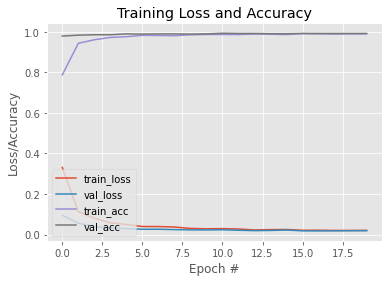

In [26]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [2]:
import cv2

In [27]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/Object-Detection-API-master/detections/frnds.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/HP PC/Desktop/Folder/DeepLearning/Object-Detection-API-master/detections/frnds.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


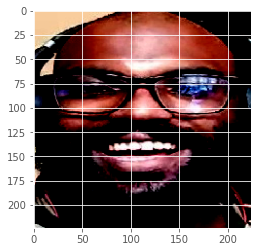

1/1 [==============================] - 0s 0s/step


array([[0.28605863, 0.02103754, 0.6929039 ]], dtype=float32)

In [28]:
inputTest = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/sandynomask.jpg'
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/sandynomask.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


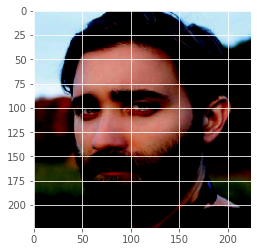

1/1 [==============================] - 0s 0s/step


array([[1.9570634e-02, 5.4959095e-05, 9.8037440e-01]], dtype=float32)

In [31]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture7.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


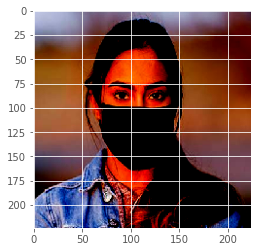

1/1 [==============================] - 0s 0s/step


array([[5.5893365e-04, 9.9907315e-01, 3.6795245e-04]], dtype=float32)

In [32]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture10.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


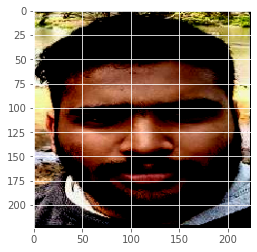

1/1 [==============================] - 0s 16ms/step


array([[0.05555215, 0.02336221, 0.92108566]], dtype=float32)

In [33]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture2.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


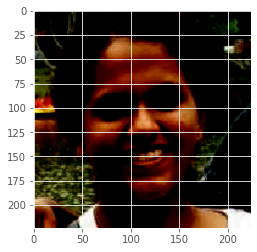

1/1 [==============================] - 0s 0s/step


array([[4.6393400e-04, 1.7477156e-04, 9.9936134e-01]], dtype=float32)

In [34]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture3.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


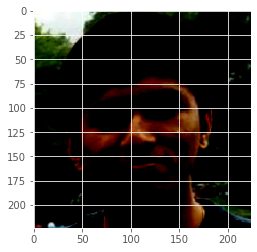

1/1 [==============================] - 0s 0s/step


array([[2.4493883e-04, 1.0032161e-05, 9.9974507e-01]], dtype=float32)

In [35]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture4.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


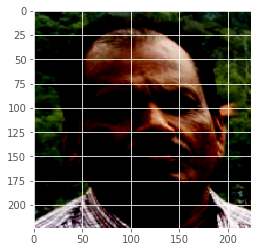

1/1 [==============================] - 0s 0s/step


array([[3.0390787e-04, 1.3261226e-03, 9.9836999e-01]], dtype=float32)

In [36]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture5.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


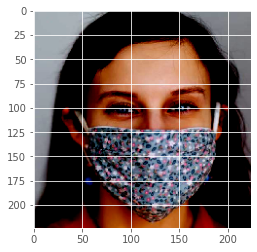

1/1 [==============================] - 0s 0s/step


array([[3.4772243e-02, 9.6496481e-01, 2.6299895e-04]], dtype=float32)

In [37]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture6.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


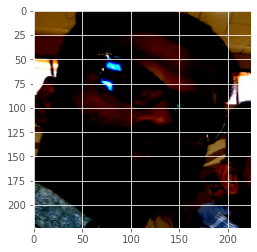

1/1 [==============================] - 0s 0s/step


array([[0.3059966 , 0.00239076, 0.6916126 ]], dtype=float32)

In [38]:
inputTest = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture8.jpg'
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture8.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


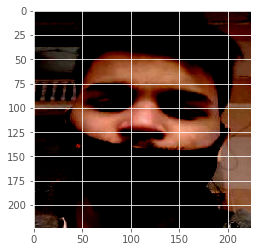

1/1 [==============================] - 0s 0s/step


array([[2.0425919e-01, 7.9556865e-01, 1.7216973e-04]], dtype=float32)

In [39]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture9.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


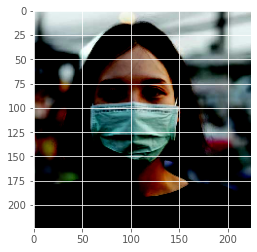

1/1 [==============================] - 0s 995us/step


array([[9.9995899e-01, 4.1006697e-05]], dtype=float32)

In [64]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture11.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


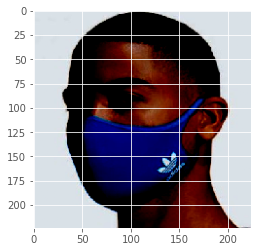

1/1 [==============================] - 0s 999us/step


array([[9.9982458e-01, 1.7546612e-04]], dtype=float32)

In [65]:
img_path = 'C:/Users/HP PC/Desktop/Folder/DeepLearning/faceBinary/Capture12.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


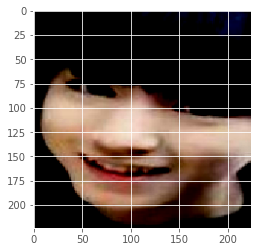

1/1 [==============================] - 0s 688us/step


array([[0.3771843 , 0.62281567]], dtype=float32)

In [49]:
img_path = 'C:/Users/HP PC/Desktop/Face-Mask-Detection-master/dataset/without_mask/0_0_wangjunkai_0001.jpg'
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
plt.imshow(image)
plt.show()
model.predict(np.array(image).reshape(-1,224,224,3),verbose=1)